# Improved LSTM baseline

This kernel is a somewhat improved version of [Keras - Bidirectional LSTM baseline](https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051) along with some additional documentation of the steps. (NB: this notebook has been re-run on the new test set.)

In [1]:
# Fast Text
# Increase the glove Embedding
# Use Fast Text to generate the embedding

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


We include the GloVe word vectors in our input files. To include these in your kernel, simple click 'input files' at the top of the notebook, and search 'glove' in the 'datasets' section.

In [2]:
path = 'data/'
EMBEDDING_FILE=f'wv/glove.twitter.27B.200d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'

Set some basic config parameters:

In [3]:
embed_size = 200 # how big is each word vector
max_features = 500000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a comment to use

Read in our data and replace missing values:

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [5]:
# from nltk.corpus import stopwords
# cachedStop =  stopwords.words('english')
# pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
# def cleanwords(sent):
#     return ' '.join([word.lower() for word in sent.lower().split() if word not in cachedStop ])
    # return pattern.sub('', sent.lower())

# def cleanchars(sent):
#     return sent.translate(translator)


In [6]:
print(len(set(train['comment_text'].str.cat(sep=" ").split())))
print(len(set(test['comment_text'].str.cat(sep=" ").split())))

532299
611496


(array([  1.41929000e+05,   1.23380000e+04,   2.56300000e+03,
          1.12000000e+03,   8.27000000e+02,   6.33000000e+02,
          1.22000000e+02,   2.30000000e+01,   1.20000000e+01,
          4.00000000e+00]),
 array([  1.00000000e+00,   1.42000000e+02,   2.83000000e+02,
          4.24000000e+02,   5.65000000e+02,   7.06000000e+02,
          8.47000000e+02,   9.88000000e+02,   1.12900000e+03,
          1.27000000e+03,   1.41100000e+03]),
 <a list of 10 Patch objects>)

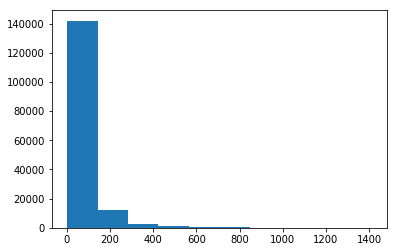

In [7]:
# Length of Comment
plt.hist(train['comment_text'].apply(lambda x:len(x.split())))

(array([  1.46584000e+05,   4.37200000e+03,   1.36500000e+03,
          7.16000000e+02,   1.13000000e+02,   9.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([    0. ,   232.1,   464.2,   696.3,   928.4,  1160.5,  1392.6,
         1624.7,  1856.8,  2088.9,  2321. ]),
 <a list of 10 Patch objects>)

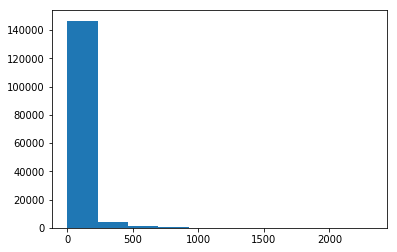

In [8]:
plt.hist(test['comment_text'].apply(lambda x:len(x.split())))

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [9]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [10]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [11]:
embeddings_index['hello']

array([ -3.37119997e-01,  -2.16910005e-01,  -6.63649989e-03,
        -4.16249990e-01,  -1.25549996e+00,  -2.84659993e-02,
        -7.21949995e-01,  -5.28869987e-01,   7.20850006e-03,
         3.19970012e-01,   2.94250008e-02,  -1.32360002e-02,
         4.35110003e-01,   2.57160008e-01,   3.89950007e-01,
        -1.19680002e-01,   1.50350004e-01,   4.47620004e-01,
         2.84069985e-01,   4.93389994e-01,   6.28260016e-01,
         2.28880003e-01,  -4.03849989e-01,   2.73640007e-02,
         7.36790011e-03,   1.39950007e-01,   2.33459994e-01,
         6.81219995e-02,   4.84219998e-01,  -1.95780005e-02,
        -5.47510028e-01,  -5.49830019e-01,  -3.40909995e-02,
         8.00170004e-03,  -4.30649996e-01,  -1.89689994e-02,
        -8.56700018e-02,  -8.11230004e-01,  -2.10800007e-01,
         3.77840012e-01,  -3.50459993e-01,   1.36840001e-01,
        -5.56609988e-01,   1.68349996e-01,  -2.29519993e-01,
        -1.61840007e-01,   6.73449993e-01,  -4.65970010e-01,
        -3.18339989e-02,

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [12]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.0039050116, 0.38177028)

In [13]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue # greater than max word features
    embedding_vector = embeddings_index.get(word) # out of word vocabulary
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [14]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we're ready to fit out model! Use `validation_split` when not submitting.

In [15]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 4424s 31ms/step - loss: 0.0520 - acc: 0.9810 - val_loss: 0.0451 - val_acc: 0.9827
Epoch 2/2
143613/143613 [==============================] - 4358s 30ms/step - loss: 0.0358 - acc: 0.9856 - val_loss: 0.0446 - val_acc: 0.9834


And finally, get predictions for the test set and prepare a submission CSV:

In [16]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('glove300.csv', index=False)

153164/153164 [==============================] - 49s 321us/step


In [4]:
# sample_submission.to_csv('base_test.csv',index=False)

In [19]:
# test_submission = pd.read_csv('data/sample_submission.csv')
# len(test_submission)

In [ ]:
# Baseline Score
# loss: 0.0417 - acc: 0.9840 - val_loss: 0.0451 - val_acc: 0.9829 --> AUC : 0.9787

